In [245]:
#----------------------------#
#       import packages      #
#----------------------------#

import numpy as np
from scipy.integrate import solve_ivp, complex_ode, odeint, quad
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton_krylov
from scipy import interpolate
from decimal import Decimal

import latex
# Use LaTeX font
#from matplotlib import rc
#rc('text', usetex=True)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'times',
})

# ignore the runtime warnings
import warnings
warnings.filterwarnings('ignore')

In [246]:
#----------------------------#
# Constants and Coefficients #
#----------------------------#

g = np.longdouble(0.64) # Gauge Coupling Constants
mpl = np.longdouble(2.4e18) # Reduce Planck Mass [GeV]
coeff = np.array([0.05, 1, 1], dtype = np.longdouble) # Fiducial Choice of the Potential Parameters

pi = Decimal('3.1415926535897932384626433832795')

In [247]:
#--------------------#
#  Benchmark Values  #
#--------------------#

# The ordering of the values are ['mu' (GeV), 'beta', 'f' (GeV)]
Model_D = np.array([1.1e8, 1e6, 1e14], dtype = np.longdouble)
Model_C = np.array([3.7e9, 1e6, 1e17], dtype = np.longdouble)
Model_E = np.array([3.7e9, 5e7, 1e17], dtype = np.longdouble)
Model_F = np.array([3.5e9, 1e6, 1e17], dtype = np.longdouble)
Model_G = np.array([3.5e9, 5e8, 1e17], dtype = np.longdouble)
Model_H = np.array([3.5e9, 1e9, 1e17], dtype = np.longdouble)
Model_I = np.array([3.5e9, 5e10, 1e17], dtype = np.longdouble)
model_test = np.array([9310176.080493832, 3432250.2661242913, 678545457339.3569])
Model_T = np.array([3.5e9, 1.5e9, 1e17], dtype = np.longdouble)

def calc_model(f_pt, beta_pt):
    f = f_pt
    beta = beta_pt
    mu = 10**(0.499* np.log10(f_pt) + 1.065)
    return (mu, beta, f)

Model_l = calc_model(10**18.2, 10**12)
Model_m = calc_model(10**18.2, 10**10)

In [248]:
def V_higgs(h, model, coeff, reparam):
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    higgs_angle = h/f
    
    if reparam == False:
        V = mu**4*(c0 + c2*(np.sin(higgs_angle))**2 + c4*(np.sin(higgs_angle))**4)
    else:
        eps = h
        V = mu**4*c0
    return V

def Vh(h, model, coeff, reparam):
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    higgs_angle = h/f
    
    if reparam == False:
        Vh = mu**4*(2*c2*np.sin(higgs_angle)*np.cos(higgs_angle)+4*c4*np.cos(higgs_angle)*(np.sin(higgs_angle))**3)/f
    else:
        eps = h
        Vh = -2*c2*(mu**4/f)*eps*np.pi
    return Vh

def Vhh(h, model, coeff, reparam):
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    higgs_angle = h/f
    
    if reparam == False:
        Vhh = (2*mu**4/f**2)*((c2 + c4)*np.cos(2*higgs_angle) - c4*np.cos(4*higgs_angle))
    else:
        eps = h
        Vhh = 2*c2*mu**4/f**2
    return Vhh 

def hubble(h, model, coeff, reparam):
    hub2 = V_higgs(h, model, coeff, reparam)/3
    hub = np.sqrt(hub2)
    
    return hub

def psi_bg(h, model, coeff, reparam):
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    lamb = g*beta
    
    hub = hubble(h, model, coeff, reparam)
    vh = Vh(h, model, coeff, reparam)
    
    if reparam == False:
        psi_bg = (-f**2*vh/(3*g*h*hub*lamb**2))**(1/3)
    else:
        eps = h
        psi_bg = ((2*c2*mu**4)/(3*g*lamb**2*hub))**(1/3)*eps**(1/3)

    return psi_bg

def m_eff(h, model, coeff, reparam):
    hub = hubble(h, model, coeff, reparam)
    psi = psi_bg(h, model, coeff, reparam)
    m = g*psi/hub

    return m

def N_integrand(h, model, coeff, reparam):
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    lamb = g*beta
    
    hub = hubble(h, model, coeff, reparam)
    psi = psi_bg(h, model, coeff, reparam)
    m_psi = m_eff(h, model, coeff, reparam)
    

    if reparam == False:
        dh = (f**2/lamb**2)*(hub/h)*(2*m_psi + 2/m_psi)
        dN = hub/dh
    else:
        dN = (np.pi*lamb)**2*(h-1)*(2*m_psi + 2/m_psi)**(-1)
    
    return dN

def delta_N(h_i, model, coeff, reparam):

    '''
    Calculate the number of e-folds before the end of inflation
    --------------------------------------------------
    h_i: background higgs field value when it cross the horizon
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    lamb = g*beta
    
    if reparam == False:
        h_f = np.pi*f

        res = quad(N_integrand, h_i, h_f, args=(model, coeff, reparam))[0]
        
    else:
        eps_i = h_i
        eps_f = 0 
        
        res = quad(N_integrand, eps_i, eps_f, args=(model, coeff, reparam))[0]
    return res

#print(delta_N(0.50001*model_test[2]*np.pi/mpl, model_test, coeff, False))
#print(delta_N(0.00000000030034, Model_E, coeff, True))
#print(delta_N(2.904E-10, Model_E, coeff, True))

print(delta_N(0.5000*Model_l[2]*np.pi/mpl, Model_l, coeff, False))

5.4347575566078024e+20


In [249]:
def solve_hc_higgs(model, coeff, N_ref, reparam):
    '''
    Solve for the horizon-crossing value of the higgs field
    -------------------------------------------------------
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    N_ref: number of e-folds before the end of inflation (50 or 60)
    '''
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    
    function = lambda theta: delta_N(theta, model, coeff, reparam)
    
    maxiter = 26
    n_iter = 1
    tol = 0.1
    
    if reparam == False:
        x0 = Decimal('0.9')
        error = function(np.longdouble(x0) * np.pi * f) - 60
        while abs(error) > tol and n_iter <= maxiter:
            while error > 0:
                x0 = x0 + Decimal('0.9') * Decimal('0.1')**n_iter
                n_iter += 1
                error = function(np.longdouble(x0) * np.pi * f) - 60
                #print(x0)
                
            while error < 0: 
                x0 = x0 - Decimal('0.1')**n_iter
                error = function(np.longdouble(x0) * np.pi * f) - 60
                #print(x0)
                #print(error)
        hc_higgs_angle = np.longdouble(x0 * pi) * f
    
        #print(x0)
    else:
        y0 = Decimal('0.1')
        error = function(np.longdouble(y0)) - 60
        while abs(error) > tol and n_iter <= maxiter:
            while error > 0:
                y0 = y0 - Decimal('0.1')**n_iter + Decimal('0.1')**(n_iter+1)
                n_iter += 1
                error = function(np.longdouble(y0)) - 60
                #print(function(np.longdouble(y0)))
                #print(y0)
        
            while error < 0:
                y0 = y0 + Decimal('0.1')**n_iter
                error = function(np.longdouble(y0)) - 60
                #print(function(np.longdouble(y0)))
                #print(y0)
                
        hc_higgs_angle = y0 
        
    return hc_higgs_angle

root = solve_hc_higgs(Model_l, coeff, 60, True)
print(root)
print(delta_N(root, Model_l, coeff, True))

1.318E-20
60.05202114873176


In [250]:
#  Number of e-folds #
def N_efold(model):
    '''
    Sanity Check: Calculate the numebr of e-folds the inflation last
    --------------------------------------------------
    model: benchmark models
    '''
    mu, beta, f = model

    N = 60*((g/0.64)**2)*((beta/(3*10**6))**(8/3))*((mu/(8*10**6))**(4/3))
    N_alt = 60*((g/0.64)**2)*((beta/(3*10**6))**(8/3))*((f/(5*10**11))**(2/3))

    return N, N_alt

print(N_efold(model_test)[1])

105.30388470819167


In [251]:
def load_param(model, coeff, N_ref, print_param = False):
    '''
    Load The Coefficients For A Given Set of Benchmark Values
    ---------------------------------------------------------
    model: benchmark models
    coeff: full potential coefficients choice
    V_type: potential types (minimal/full)
    N_ref: reference number of e-folds before the end of inflation (50 or 60)
    ---------------------------------------------------------
    Return:
    hbar: higgs field value when horizon crossing
    vhh: V''(h) f
    Hubble: hubble parameter when horizon crossing
    psi: gauge field value when horizon crossing
    m: dimensionless effective gauge mass
    Lambda：a constant parameter (lambda^2*psi^2/f^2)
    '''

    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    N = delta_N(0.50000*np.pi*f, model, coeff, False)
    
    if N > 1e6:
        #print("We expand the potential")
        reparam = True
        epsilon = np.longdouble(solve_hc_higgs(model, coeff, N_ref, reparam))
        hbar = (1-epsilon)*np.pi*f
        
        vhh = Vhh(epsilon, model, coeff, reparam)
        Hubble = hubble(epsilon, model, coeff, reparam)
        psi = psi_bg(epsilon, model, coeff, reparam)
        m = m_eff(epsilon, model, coeff, reparam)
        lamb = g*beta
        Lambda = (lamb**2/f**2)*psi
        Gamma_c = Lambda*hbar*m
        Psi_c = 3*Lambda*m*psi
        Beta_c = np.sqrt(2)*Lambda*hbar*m
        nu = np.sqrt(2)*Lambda*hbar
        
    else:
        reparam = False
        
        hbar = np.longdouble(solve_hc_higgs(model, coeff, N_ref, reparam))
        vhh = Vhh(hbar, model, coeff, reparam)
        Hubble = hubble(hbar, model, coeff, reparam)
        psi = psi_bg(hbar, model, coeff, reparam)
        m = m_eff(hbar, model, coeff, reparam)
        
        lamb = g*beta
        Lambda = (lamb**2/f**2)*psi
        Gamma_c = Lambda*hbar*m
        Psi_c = 3*Lambda*m*psi
        Beta_c = np.sqrt(2)*Lambda*hbar*m
        nu = np.sqrt(2)*Lambda*hbar
    
    # Four Regions
    #region1 = Lambda*hbar*m_psi
    #region2 = m_psi
    #region3 = np.sqrt(2)*m_psi/(Lambda*Hubble)
    
    
    # Initial Condition for the scalar modes Equations of Motion
    A = 1.0
    B = nu*A/np.sqrt(Beta_c**2 + nu**2)
    C = Beta_c*A/np.sqrt(Beta_c**2 + nu**2)
    x0 = np.sqrt(2)*m*Lambda*hbar
    
    A_prime = 1
    B_prime = 1
    C_prime = 1

    initial0 = [A, A_prime, B, B_prime, C, C_prime]
    
    # Instability
    tensor_low = 2*m + 1/m - np.sqrt(2*m**2+2+1/m**2)
    tensor_up = 2*m + 1/m + np.sqrt(2*m**2+2+1/m**2)

    # Print Input Parameters
    if print_param == True:
        print("##==========================================##")
        print("##          Solve Little Higgs ODE          ##")
        print("##==========================================##")
        print(" ")
        print("#================ Model Params ==============#")
        print(" ")
        print("Strong Scale(μ):           ", "%e" %mu, '[GeV]')
        print("CS coupling(β):            ", "%e" %beta)
        print("Decay Constant(f):         ", "%e" %f, '[GeV]')
        print("")
        print("#============ Scalar Modes Params ===========#")
        print(" ")
        print("N of e-folds:              ", "%e" %N)
        print("Higgs θ:                   ", "%e" %(hbar/f))
        print("Higgs Field:               ", "%e" %hbar)
        print("H:                         ", "%e" %Hubble)
        print("V,hh:                      ", "%e" %vhh)
        print("ψ:                         ", "%e" %psi)
        print("m_ψ:                       ", "%e" %m)
        print("Λ:                         ", "%e" %Lambda)
        print(" ")
        print("#=============== Coefficients ===============#")
        print(" ")
        print("Psi_c:                     ", "%e" %Psi_c)
        print("Beta_c:                    ", "%e" %Beta_c)
        print("Gamma_c:                   ", "%e" %Gamma_c)
        print("nu:                        ", "%e" %nu)
        print(" ")
        print("#============ Initial Conditions ============#")
        print(" ")
        print("h:                         ", "%e" %A)
        print("φ:                         ", "%e" %B)
        print("z:                         ", "%e" %C)
        print("x0:                        ", "%e" %x0)
        print(" ")
        print("#=========== Range of Instability ===========#")
        print(" ")
        print("Scalar Modes (m_ψ^2 < 0)   ", "%e" %np.sqrt(m))
        print("Tensor Modes:              [", "%e" %tensor_low, ",", "%e" %tensor_up,"]")
        print(" ")
        print("##==========================================##")
        print(" ")
        #print("m_psi : ", "%e" %m)
        #print("Sqrt(2)*m_psi/H*Lambda: ", "%e" %(np.sqrt(2)*m/(Hubble*Lambda)))
        
        
    return N, hbar, vhh, Hubble, psi, m , x0, initial0

PARAM_test = load_param(Model_E, coeff, 60, print_param = True)
print(PARAM_test)

##==========================================##
##          Solve Little Higgs ODE          ##
##==========================================##
 
#================ Model Params ==============#
 
Strong Scale(μ):            1.541667e-09 [GeV]
CS coupling(β):             5.000000e+07
Decay Constant(f):          4.166667e-02 [GeV]

#============ Scalar Modes Params ===========#
 
N of e-folds:               3.121080e+08
Higgs θ:                    3.141593e+00
Higgs Field:                1.308997e-01
H:                          3.068353e-19
V,hh:                       6.507503e-33
ψ:                          1.758574e-14
m_ψ:                        3.668050e+04
Λ:                          1.037249e+04
 
#=============== Coefficients ===============#
 
Psi_c:                      2.007245e-05
Beta_c:                     7.043233e+07
Gamma_c:                    4.980318e+07
nu:                         1.920157e+03
 
#============ Initial Conditions ============#
 
h:                          1

In [252]:
# Data points
edm_1 = [9852544092.107998, 63637.33465004338]
edm_2 = [2263803409521451000, 11066878888639.8]
n60_1 = [970.726250869329, 477799051.2153938]
n60_2 = [2474847182081607700, 67630.6763465995]

import numpy as np

def log_log_line_equation(point_1, point_2):
    # Take logarithm of coordinates
    x1, y1 = point_1
    x2, y2 = point_2
    log_x1 = np.log(x1)
    log_y1 = np.log(y1)
    log_x2 = np.log(x2)
    log_y2 = np.log(y2)
    
    # Calculate slope
    slope = (log_y2 - log_y1) / (log_x2 - log_x1)
    
    # Calculate intercept
    intercept = log_y1 - slope * log_x1
    
    # Return equation in log-log scale
    return slope, intercept

# Example usage
edm_slope, edm_intercept = log_log_line_equation(edm_1, edm_2)
print(f"Equation of the line in log-log scale: y = {edm_slope} * log(x) + {edm_intercept}")
n60_slope, n60_intercept = log_log_line_equation(n60_1, n60_2)
print(f"Equation of the line in log-log scale: y = {n60_slope} * log(x) + {n60_intercept}")

Equation of the line in log-log scale: y = 0.9855312825780685 * log(x) + -11.617100350248517
Equation of the line in log-log scale: y = -0.24983699355843067 * log(x) + 21.70309076745581


In [253]:
# Define the points for the first line
edm_1 = np.log10([9852544092.107998, 63637.33465004338])
edm_2 = np.log10([2263803409521451000, 11066878888639.8])

# Define the points for the second line
n60_1 = np.log10([970.726250869329, 477799051.2153938])
n60_2 = np.log10([2474847182081607700, 67630.6763465995])

# Calculate the slope for the first line
edm_slope = (edm_2[1] - edm_1[1]) / (edm_2[0] - edm_1[0])

# Calculate the slope for the second line
n60_slope = (n60_2[1] - n60_1[1]) / (n60_2[0] - n60_1[0])

# Define the analytical equations of the lines
edm_equation = f"y = {edm_slope:.10f}(x - {edm_1[0]}) + {edm_1[1]}"
n60_equation = f"y = {n60_slope:.10f}(x - {n60_1[0]}) + {n60_1[1]}"

# Print the equations
print(edm_equation)
print(n60_equation)


y = 0.9855312826(x - 9.993548387096773) + 4.8037119816122065
y = -0.2498369936(x - 2.987096774193549) + 8.679245283018865


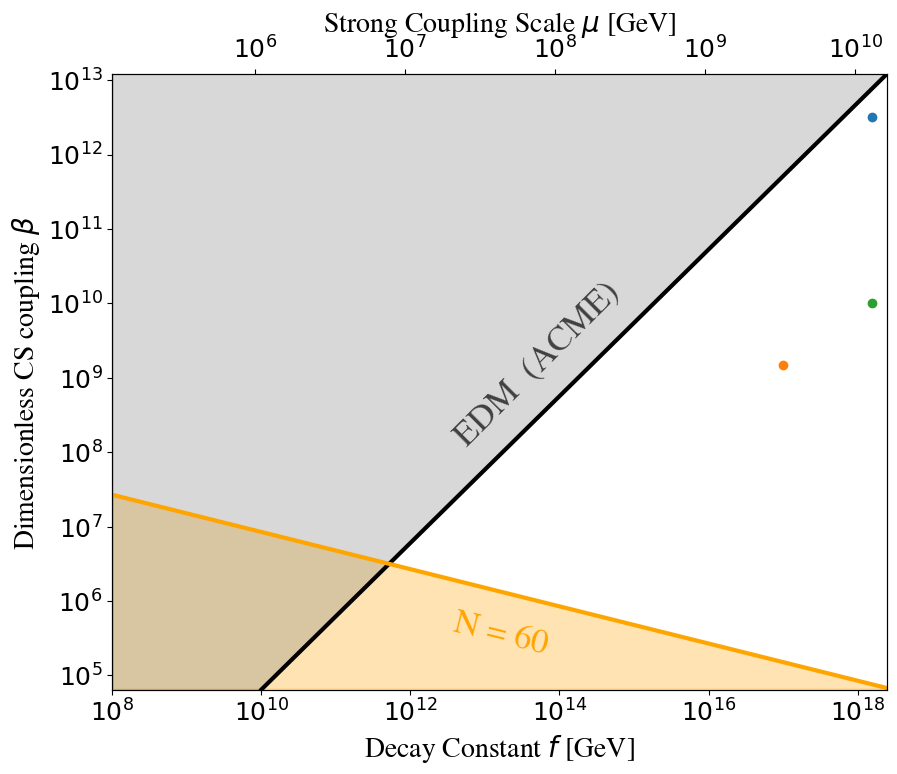

In [254]:
from matplotlib.ticker import FuncFormatter

edm_values = np.linspace(10, 18.4, 100)
n60_values = np.linspace(8, 18.4, 100)
edm_y = 0.9855312826*(edm_values - 9.993548387096773) + 4.8037119816122065
n60_y = -0.2498369936*(n60_values - 2.987096774193549) + 8.679245283018865

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(111)

ax1.plot(edm_values, edm_y, color='black', linewidth=3)
ax1.plot(n60_values, n60_y, color='orange', linewidth=3)

ax1.fill_between(n60_values, n60_y, y2 = 4.82, color='orange', alpha=0.3)
ax1.fill_betweenx(edm_y, edm_values, x2 = 8, color='gray', alpha=0.3) # Shade the area

ax1.tick_params(axis='x', labelsize=18)  
ax1.tick_params(axis='y', labelsize=18)  
ax1.set_xlabel('Decay Constant $f$ [GeV]', fontsize=20)
ax1.set_ylabel('Dimensionless CS coupling $β$', fontsize=20)

ax1.margins(x=0,y=0)

ax2 = ax1.twiny()
#ax2.set_xlim(113016, 16313997314)
ax2.set_xlim(5.05, 10.2126)
ax2.set_xlabel('Strong Coupling Scale $µ$ [GeV]', fontsize=20)
ax2.tick_params(axis='x', labelsize=18)  
#ax2.set_xscale('log')

def format_ticks(x, pos):
    if x == 0:
        return '1'
    elif x < 0:
        return r'$\frac{1}{{10^{{{:d}}}}}$'.format(int(-x))
    else:
        return r'$10^{{{:d}}}$'.format(int(x))
    
ax1.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax1.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax2.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.text(7.3, 8.1, 'EDM  (ACME)', rotation = 45, fontsize = 25, alpha=0.7)
plt.text(7.3, 5.3, 'N = 60', rotation = -14, fontsize = 25, color='orange')

ax1.scatter((18.2),(12.5))
ax1.scatter((np.log10(Model_T[2])),(np.log10(Model_T[1])))
ax1.scatter((np.log10(Model_m[2])),(np.log10(Model_m[1])))

plt.show()

# Tensor Modes

In [255]:
from scipy.signal import find_peaks
from scipy.special import gamma
from matplotlib.ticker import FuncFormatter


In [256]:
def sec(x):
    return 1/ np.cos(x)

def csch(x):
    return 1/np.sinh(x)

def m_func(m_psi):
    return 2*(1+m_psi**2)

def mt_func(m_psi):
    return 2*(2*m_psi+1/m_psi)

def alpha_func(m_psi):
    alpha = (2*m_psi+1/m_psi)*1j
    return alpha

def beta_func(m_psi):
    beta = 1j*np.sqrt(2*(1+m_psi**2)-1/4)
    return beta

def I_1(m, m_t, alpha, beta):
    term1 = (m**2 - 2j * m * m_t + 2 * m - 2 * m_t**2) * sec(np.pi * beta) * np.sinh(-1j * np.pi * alpha) * gamma(alpha) / (2 * m * (m + 2))
    term2 = -np.pi**2 * (m**2 + 2j * m * m_t + 2 * m - 2 * m_t**2) * sec(np.pi * beta) * csch(-1j * np.pi * alpha) / (2 * m * (m + 2) * gamma(alpha + 1) * gamma(-alpha - beta + 0.5) * gamma(-alpha + beta + 0.5))
    return term1 + term2

def I_2(m, m_t, alpha, beta):
    term1 = np.pi * sec(np.pi * beta) * gamma(-alpha) / (2 * gamma(-alpha - beta + 0.5) * gamma(-alpha + beta + 0.5))
    term2 = -np.pi * sec(np.pi * beta) * gamma(1 - alpha) / (m * gamma(-alpha - beta + 0.5) * gamma(-alpha + beta + 0.5))
    term3 = (np.pi * m * sec(np.pi * beta) - 1j * np.pi * m_t * sec(np.pi * beta)) / (2 * m * gamma(1 - alpha))
    return term1 + term2 + term3

def I_3(m, m_t, alpha, beta):
    term1 = np.pi**2 * (m + 1j * m_t) * sec(np.pi * beta) * csch(-1j * np.pi * alpha) / (m * (m + 2) * gamma(1j * alpha) * gamma(-alpha - beta + 0.5) * gamma(-alpha + beta + 0.5))
    term2 = np.pi * (m_t + 1j * m) * sec(np.pi * beta) / (m * (m + 2) * gamma(-1j * alpha))
    return term1 + term2


def A_k(k, alpha, beta):
    numerator = gamma(-alpha + beta + 0.5)
    denominator = np.sqrt(2 * k) * ((2j)**(-alpha) * gamma(2 * beta + 1))
    return numerator / denominator

def B_k(k, alpha, beta):
    numerator = gamma(-alpha + beta + 0.5)
    denominator = np.sqrt(2 * k) * gamma(alpha + beta + 0.5)
    return numerator / denominator * (2**alpha) * (1j**(beta + 1)) * ((-1j)**(alpha - beta))

def delta_plus(k, H, psi, m_psi):
    
    alpha = alpha_func(m_psi)
    beta = beta_func(m_psi)
    
    m = m_func(m_psi)
    m_t = mt_func(m_psi)
    
    I1 = I_1(m, m_t, alpha, beta)
    I2 = I_2(m, m_t, alpha, beta)
    I3 = I_3(m, m_t, alpha, beta)
    
    Bk = B_k(k, alpha, beta)

    term1 = H**2 / (2 * np.pi**2)
    term2 = 4 * k * (H**2) / (np.pi**2) * psi**2 * np.abs(Bk) * np.abs(I1 + m_psi * I2 - m_psi**2 * I3)**2
    
    return term1 + term2

def delta_minus(k, H, psi, m_psi):
    term1 = H**2 / (2 * np.pi**2)
    return term1

In [257]:
def format_ticks(x, pos):
    if x == 0:
        return '1'
    else:
        return r'$10^{{{:d}}}$'.format(int(x))

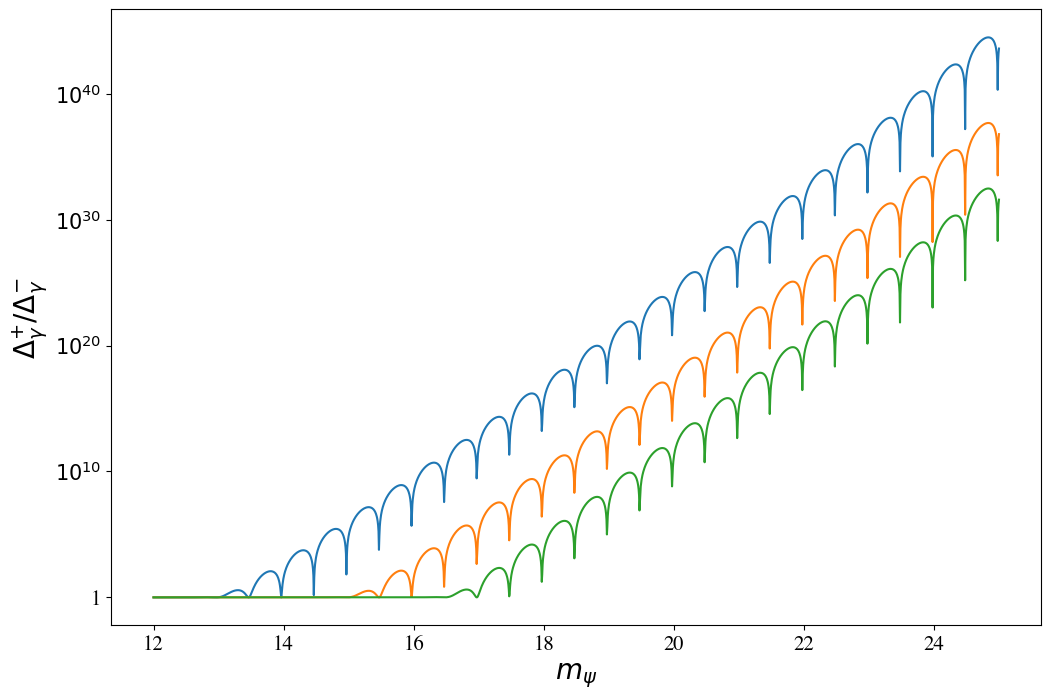

In [271]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

def tensor_ratio_plot(k, model, coeff, N_ref):
    
    #m_list = np.logspace(-1.5, 1.5, 2000)
    m_list = np.linspace(12, 25, 2000)
    
    N, hbar, vhh, Hubble, psi, m_psi , x0, _ = load_param(model, coeff, N_ref)
    
    #print(m_psi)
    
    log_ps_plus = delta_plus(0.002, Hubble, psi, m_list)
    log_ps_minus = delta_minus(0.002, Hubble, psi, m_list)
    ratio = log_ps_plus/log_ps_minus
    
    plt.plot(m_list, np.log10(ratio))
    
    ax.tick_params(axis='x', labelsize=15)  
    ax.tick_params(axis='y', labelsize=15)  
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    ax.set_xlabel('$m_\psi$', fontsize=20)
    ax.set_ylabel('$\Delta_\gamma^\plus/\Delta_\gamma^\minus$', fontsize=20)

tensor_ratio_plot(0.002,  Model_C, coeff, 60)
tensor_ratio_plot(0.002,  Model_E, coeff, 60)
tensor_ratio_plot(0.002,  Model_H, coeff, 60)
plt.savefig("tensor_ratio_plot.png", dpi=300)
plt.show()

In [259]:
# Data points
edm_1 = [9852544092.107998, 63637.33465004338]
edm_2 = [2263803409521451000, 11066878888639.8]
n60_1 = [970.726250869329, 477799051.2153938]
n60_2 = [2474847182081607700, 67630.6763465995]

def log_log_line_equation(point_1, point_2):
    # Take logarithm of coordinates
    x1, y1 = point_1
    x2, y2 = point_2
    log_x1 = np.log(x1)
    log_y1 = np.log(y1)
    log_x2 = np.log(x2)
    log_y2 = np.log(y2)
    
    # Calculate slope
    slope = (log_y2 - log_y1) / (log_x2 - log_x1)
    
    # Calculate intercept
    intercept = log_y1 - slope * log_x1
    
    # Return equation in log-log scale
    return slope, intercept

# Example usage
edm_slope, edm_intercept = log_log_line_equation(edm_1, edm_2)
print(f"Equation of the line in log-log scale: y = {edm_slope} * log(x) + {edm_intercept}")
n60_slope, n60_intercept = log_log_line_equation(n60_1, n60_2)
print(f"Equation of the line in log-log scale: y = {n60_slope} * log(x) + {n60_intercept}")

Equation of the line in log-log scale: y = 0.9855312825780685 * log(x) + -11.617100350248517
Equation of the line in log-log scale: y = -0.24983699355843067 * log(x) + 21.70309076745581


In [262]:
from scipy.optimize import curve_fit

k = 0.05 #(1/Mpc)

def tensor_ps(model, coeff, N_ref):
    N, hbar, vhh, Hubble, psi, m_psi , x0, _ = load_param(model, coeff, N_ref)
    
    #print(m_psi)
    
    if m_psi > 50:
        m_list = np.linspace(1, 50, 1000)
        log_ps_plus = np.log10(delta_plus(k, Hubble, psi, m_list))
    
        def poly_func(x, c, d):
            return c * x + d
    
        popt, _ = curve_fit(poly_func, m_list[700:1000], log_ps_plus[700:1000])

        c, d = popt
        m_plot = np.linspace(30, 100, 1000)
        log_ps_plus_fit = poly_func(m_plot, c, d)

        #plt.plot(m_plot, log_ps_plus_fit, '-', linewidth=1)
        #plt.plot(m_list, log_ps_plus)
        #plt.show()
    
        ps_plus = poly_func(m_psi, c, d)
        ps_minus = np.log10(delta_minus(k, Hubble, psi, m_psi))
        ps_total = ps_plus + np.log10(2) # We neglect the contribution for ps_minus 
        
    else:
        ps_plus = np.log10(delta_plus(k, Hubble, psi, m_psi))
        ps_minus = np.log10(delta_minus(k, Hubble, psi, m_psi))
        ps_total = np.log10(2 * 10**ps_plus + 2 * 10**ps_minus)
    
    return ps_plus, ps_minus, ps_total

tensor_ps(Model_H, coeff, 60)

(393.7205221554906, -38.418053780881216, 394.02155215115454)

In [265]:
from tqdm import tqdm

N_res = 70
f_contour = np.logspace(8, 18.4, N_res, dtype = np.longdouble)
b_contour = np.logspace(4.8, 13.044, N_res, dtype = np.longdouble)
F, B = np.meshgrid(f_contour, b_contour)

ps_plus_map = np.zeros((N_res, N_res), dtype = np.longdouble)
ps_minus_map = np.zeros((N_res, N_res), dtype = np.longdouble)
ps_total_map = np.zeros((N_res, N_res), dtype = np.longdouble)

for ff in tqdm(range(N_res)):
    for bb in range(N_res):
        
        edm_yy = np.exp(edm_intercept) * np.power(f_contour[ff], edm_slope)
        n60_yy = np.exp(n60_intercept) * np.power(f_contour[ff], n60_slope)
        model = calc_model(F[bb,ff], B[bb,ff])
        N, hbar, vhh, Hubble, psi, m_psi , x0, _ = load_param(model, coeff, 60)
        
        if (b_contour[bb] <= edm_yy) and (b_contour[bb] >= n60_yy) and (m_psi >= np.sqrt(2)):
            ps_plus_map[bb,ff], ps_minus_map[bb,ff], ps_total_map[bb,ff] = tensor_ps(model, coeff, 60)
            
        else:
            
            ps_plus_map[bb,ff] = np.NaN
            ps_minus_map[bb,ff] = np.NaN
            ps_total_map[bb,ff] = np.NaN

100%|███████████████████████████████████████████| 70/70 [12:31<00:00, 10.73s/it]


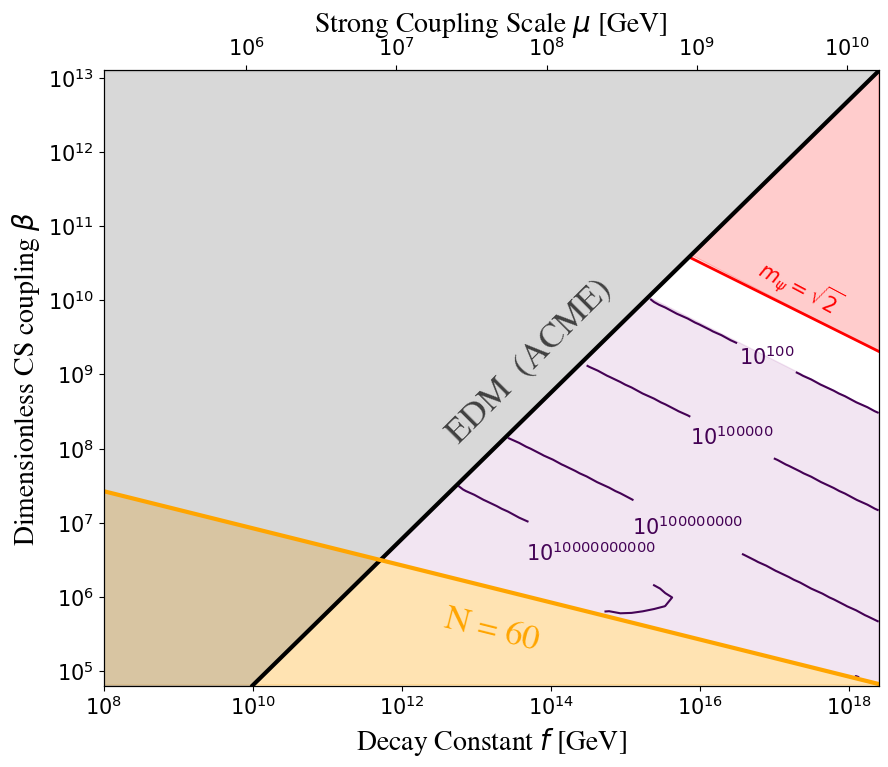

In [272]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

mpsi_line_x = np.linspace(15.86, 18.3966, 100)
mpsi_line_y = -0.4994 * mpsi_line_x + 18.50
ax1.plot(mpsi_line_x, mpsi_line_y, color = "red", linewidth=2)
plt.text(16.7, 9.8, '$m_\psi = \sqrt{2}$', color='red', fontsize=15, rotation = -28)

CS = ax1.contour(np.log10(F), np.log10(B), ps_total_map, levels = [1e2, 1e5, 1e8, 1e10, 1e12])
plt.clabel(CS, inline=True, fontsize=15, fmt = lambda x: f'$10^{{{x:.0f}}}$')

for label in CS.labelTexts:
    label.set_rotation(0)

ax1.plot(edm_values, edm_y, color='black', linewidth=3)
ax1.plot(n60_values, n60_y, color='orange', linewidth=3)

ax1.fill_between(n60_values, n60_y, y2 = 4.82, color='orange', alpha=0.3)
ax1.fill_betweenx(edm_y, edm_values, x2 = 8, color='gray', alpha=0.3) # Shade the area

ax1.tick_params(axis='x', labelsize=15)  
ax1.tick_params(axis='y', labelsize=15)  
ax1.set_xlabel('Decay Constant $f$ [GeV]', fontsize=20)
ax1.set_ylabel('Dimensionless CS coupling $β$', fontsize=20)

ax1.margins(x=0,y=0)

ax2 = ax1.twiny()
#ax2.set_xlim(113016, 16313997314)
ax2.set_xlim(5.05, 10.2126)
ax2.set_xlabel('Strong Coupling Scale $µ$ [GeV]', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)  
#ax2.set_xscale('log')
    
ax1.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax1.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax2.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.text(7.3, 8.1, 'EDM  (ACME)', rotation = 45, fontsize = 25, alpha=0.7)
plt.text(7.3, 5.3, 'N = 60', rotation = -14, fontsize = 25, color='orange')

x_mpsi = (15.9, 18.4, 18.4)
y_mpsi = (10.6, 13.1, 9.3)
ax1.fill(x_mpsi, y_mpsi, alpha=0.2, color='red')

x_tensor = (15.3, 18.40, 18.4, 11.71)
y_tensor = (10.05, 8.48, 4.82, 6.50)
ax1.fill(x_tensor, y_tensor, alpha=0.1, color='purple')

plt.savefig("tensor_ruleout_parameter_space.png", dpi=300)

plt.show()